# Bitcoin Price Movement Prediction

##### Project Goal:
The aim of this project is to use historical Bitcoin data and machine learning classification techniques to attempt to classify a given day as an opportunity to buy or sell Bitcoin. More specifically, the model I build will determine if the price will go up or down X number of days from the current date. I am particularly interested in predictions on a higher timeframe, say 7-30 days. The idea here is that checking Bitcoin prices on a regular basis is cumbersome and may lead to overtrading and trading losses. It would be beneficial to have a model that highlights days that are ideal for buying and holding for a week or more. This type of trading, where trades last for upwards of a few days, is referred to as Swing Trading. Ideally, the model would be able to classify a given day as "Strong Buy" or "Strong Sell," indicating that current conditions are consistent with large price moves in the coming X days.

##### Model Selection:
For this project, I selected the Random Forest Classification model from the Sci-Kit Learn package. The nature of a random forest model is very well suited to time series data such as price movement in an asset like Bitcoin. The way in which you might go about deciding whether to enter a trade is similar to the methodology used in random forest. A trader might have a long list of indicators. Any one indicator, absent all other indicators, will not convince an experienced trader to enter a trade. Rather, she will examine her list of indicators in search of "confluence," or the agreement of multiple indicators pointing to the same future price movement (up, down, or sideways). Random forest models can take it one step further, examining and randomizing the order in which indicators are inspected. While a human trader might have her favorite go-to indicator, the random forest model can create an ensemble of "traders," each with their own indicator preferences. This forest of "traders" then votes on how the price is likely to move in the future. 

##### Indicator Notes:
It should be noted that I am using the daily candles when calculating the indicators used in this analysis. The daily timeframe is a common view for swing traders planning trades in the multi-week range. Day traders may use one hour, fifteen minute, or even five minute charts when planning their trades. The indicator calculations at lower timeframes (e.g. 1 hour, 15 minutes) or higher timeframes (e.g. 2 days, 1 week) would be wildly different that the calculations used here. Swing traders also look at lower and higher timeframe charts when planning their trades, but for this analysis, I will stick to the daily indicators.

### Step 1: Import packages

In [12]:
import pandas as pd
import numpy as np
from math import ceil, floor

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from itertools import product, combinations
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pickle
from pathlib import Path

from data.db_interaction import DatabaseInteraction
from data.time_series_functions import add_regression_column, get_slope

from jesse import research

### Step 2: Import Data

In [13]:
# Perform db queries and save to df's.
DI = DatabaseInteraction()

ichimoku_df = DI.query_to_df(DI.query_all_data('ichimoku'))
macd_df = DI.query_to_df(DI.query_all_data('macd'))
rsi_df = DI.query_to_df(DI.query_all_data('rsi'))
bbands_df = DI.query_to_df(DI.query_all_data('bbands'))
volume_df = DI.query_to_df(DI.query_all_data('volume'))

glassnode_df = DI.query_to_df(DI.query_all_data('glassnode'))

In [14]:
#Query db for candle data. Only get data for range captured for Ichimoku. Add date column from timestamp.
ichimoku_min_date = ichimoku_df['date'].min()
ichimoku_max_date = ichimoku_df['date'].max()
start_date = ichimoku_min_date.strftime('%Y-%m-%d')
end_date = ichimoku_max_date.strftime('%Y-%m-%d')

exchange ='Coinbase'
coin = 'BTC-USD'
period = '1D'

research.init()
candles_array = research.get_candles(exchange, coin, period, start_date, end_date)
candles_df = pd.DataFrame(candles_array, columns = ['timestamp', 'open', 'close', 'high', 'low', 'volume'])

### Step 3: Add Additional Columns to Data

In [15]:
# Create candles column for date from timestamp
candles_df['date'] = candles_df.apply(lambda row: datetime.fromtimestamp(row['timestamp'] / 1000).date(), axis=1)

In [16]:
# Convert date column from timestamp to date for glassnode table
glassnode_df['date'] = glassnode_df['date'].apply(lambda x: x.date())

# Transform glassnode columns (normalize by price, create rolling windows)
glassnode_df['new_over_active'] = glassnode_df['new_addresses'] / glassnode_df['active_addresses'].shift(1)
glassnode_df['new_over_active_30'] = glassnode_df['new_over_active'].rolling(window=30, min_periods=30).mean()
glassnode_df['active_change_perc_30'] = glassnode_df['active_addresses'].pct_change(30)

glassnode_df = glassnode_df.merge(candles_df[['date', 'close']], how='left', on='date')

glassnode_df['hash_rate_norm'] = glassnode_df['hash_rate'] / glassnode_df['close']
glassnode_df['mining_difficulty_norm'] = glassnode_df['mining_difficulty'] / glassnode_df['close']

glassnode_df['transactions_30'] = glassnode_df['transactions'].rolling(window=30, min_periods=30).mean()
glassnode_df['net_transfer_volume_30'] = glassnode_df['net_transfer_volume'].rolling(window=30, min_periods=30).mean()
glassnode_df['hash_rate_norm_30'] = glassnode_df['hash_rate_norm'].rolling(window=30, min_periods=30).mean()
glassnode_df['mining_difficulty_norm_30'] = glassnode_df['mining_difficulty_norm'].rolling(window=30, min_periods=30).mean()
glassnode_df['transaction_fees_30'] = glassnode_df['transaction_fees'].rolling(window=30, min_periods=30).mean()

In [17]:
# Create df for regression and divergence calculations
divergence_df = candles_df[['date', 'close', 'volume']].merge(macd_df[['date', 'macd']], 
                                                              how='left',
                                                              on='date'
                                                             )

divergence_df = divergence_df.merge(rsi_df[['date', 'rsi']],
                                    how='left',
                                    on='date'
                                   )

# Add regression columns to divergence_df for price (close), volume, RSI, and MACD for each rolling window size.
windows = [3, 7, 15, 30, 60, 120]    

for window in windows:
    divergence_df = add_regression_column(divergence_df, 'close', window)
    divergence_df = add_regression_column(divergence_df, 'volume', window)
    divergence_df = add_regression_column(divergence_df, 'rsi', window)
    divergence_df = add_regression_column(divergence_df, 'macd', window)

divergence_df = divergence_df.dropna(axis=0)

In [18]:
# Add price_change columns for various periods to the volume_df
price_change_periods = [1, 3, 7, 15, 30]

for period in price_change_periods:
    volume_df['price_change_' + str(period)] = volume_df['closing_price'].diff(period*-1)
    volume_df['price_change_perc_' + str(period)] = volume_df['closing_price'].pct_change(period*-1)

### Step 4:  Merge Data for Analysis

In [19]:
# Specify relevant columns from each df for use in the model
regression_metrics = ['close', 'volume', 'macd', 'rsi']
cols_divergence = ['date']

for combo in product(regression_metrics, windows):
    cols_divergence.extend([combo[0] + '_reg_norm' + str(combo[1])])

price_change_perc_cols = []
cols_volume = ['date']

for period in price_change_periods:
    price_change_perc_cols.append('price_change_perc_' + str(period))

cols_volume.extend(price_change_perc_cols)

cols_bbands = ['date', 'band_size', 'band_size_streak', 'band_size_vs_closing_price', 'closing_price_band_position']
cols_glassnode = ['date', 'nupl', 'stfd', 'market_to_thermo', 'active_addresses', 'new_addresses', 'new_over_active', 
                  'new_over_active_30', 'active_change_perc_30', 'transactions', 'transactions_30', 
                  'hash_rate', 'hash_rate_norm', 'mining_difficulty', 'mining_difficulty_norm', 'transaction_fees', 
                  'transaction_fees_30', 'net_transfer_volume', 'net_transfer_volume_30',  ]

cols_ichimoku = ['date', 't_over_k', 't_over_k_streak', 'price_over_t', 'price_over_t_streak', 'price_over_k', 
                 'price_over_k_streak', 'price_over_cloud_top', 'price_over_cloud_bottom', 'cloud_over_price', 
                 'span_a_over_b', 'future_cloud_over_price', 'future_span_a_over_b']
cols_macd = ['date', 'macd', 'signal', 'histogram', 'macd_over_signal', 'macd_over_signal_streak', 'histogram_streak', 'hist_magnitude']

In [20]:
# Merge the dfs to a single df
population_df = volume_df[cols_volume].merge(ichimoku_df[cols_ichimoku], 
                                             how='right',
                                             on='date'
                                            )

population_df = population_df.merge(macd_df[cols_macd], 
                                    how='left',
                                    on='date'
                                   )

population_df = population_df.merge(rsi_df, 
                                    how='left',
                                    on='date'
                                   )

population_df = population_df.merge(divergence_df[cols_divergence], 
                                    how='left',
                                    on='date'
                                   )

population_df = population_df.merge(bbands_df[cols_bbands], 
                                    how='left',
                                    on='date'
                                   )

population_df = population_df.merge(glassnode_df[cols_glassnode], 
                                    how='left',
                                    on='date'
                                   )

In [21]:
population_df.columns

Index(['date', 'price_change_perc_1', 'price_change_perc_3',
       'price_change_perc_7', 'price_change_perc_15', 'price_change_perc_30',
       't_over_k', 't_over_k_streak', 'price_over_t', 'price_over_t_streak',
       'price_over_k', 'price_over_k_streak', 'price_over_cloud_top',
       'price_over_cloud_bottom', 'cloud_over_price', 'span_a_over_b',
       'future_cloud_over_price', 'future_span_a_over_b', 'macd', 'signal',
       'histogram', 'macd_over_signal', 'macd_over_signal_streak',
       'histogram_streak', 'hist_magnitude', 'rsi', 'rsi_streak',
       'over_under_streak', 'close_reg_norm3', 'close_reg_norm7',
       'close_reg_norm15', 'close_reg_norm30', 'close_reg_norm60',
       'close_reg_norm120', 'volume_reg_norm3', 'volume_reg_norm7',
       'volume_reg_norm15', 'volume_reg_norm30', 'volume_reg_norm60',
       'volume_reg_norm120', 'macd_reg_norm3', 'macd_reg_norm7',
       'macd_reg_norm15', 'macd_reg_norm30', 'macd_reg_norm60',
       'macd_reg_norm120', 'rsi_re

In [22]:
population_df.describe()

,price_change_perc_1,price_change_perc_3,price_change_perc_7,price_change_perc_15,price_change_perc_30,t_over_k,t_over_k_streak,price_over_t,price_over_t_streak,price_over_k,...,transactions,transactions_30,hash_rate,hash_rate_norm,mining_difficulty,mining_difficulty_norm,transaction_fees,transaction_fees_30,net_transfer_volume,net_transfer_volume_30
count,1980.000000,1978.000000,1974.000000,1966.000000,1951.000000,1981.000000,1981.000000,1981.000000,1981.000000,1981.000000,...,1981.000000,1981.000000,1.981000e+03,1979.000000,1.981000e+03,1.979000e+03,1981.000000,1981.000000,1981.000000,1981.000000
mean,-0.001427,-0.004348,-0.010022,-0.020789,-0.039694,1.032887,20.438163,1.037302,6.828874,1.074780,...,275580.614336,275257.718980,5.529820e+07,6136.160355,3.282505e+10,3.627010e+06,0.000379,0.000379,915.079216,910.784402
std,0.042242,0.070753,0.110815,0.163397,0.241752,0.135931,62.331922,0.141027,20.835248,0.221128,...,57449.423708,49797.500021,5.312149e+07,4258.881315,3.171964e+10,2.560799e+06,0.000429,0.000388,8611.264944,2252.827430
min,-0.213849,-0.330421,-0.430535,-0.525590,-0.668003,0.681942,-160.000000,0.551527,-52.000000,0.503441,...,131726.000000,174813.133333,6.885383e+05,678.888655,4.461627e+08,3.477276e+05,0.000040,0.000060,-69789.449136,-4664.260594
25%,-0.019231,-0.040407,-0.069806,-0.118794,-0.203024,0.955852,-18.000000,0.968007,-4.000000,0.939110,...,229575.000000,228039.200000,4.412083e+06,2665.556867,2.405057e+09,1.579878e+06,0.000118,0.000128,-2906.396167,-593.682420
50%,-0.002569,-0.007144,-0.011882,-0.028410,-0.057444,1.025262,13.000000,1.021705,3.000000,1.045583,...,279519.000000,284711.200000,4.196718e+07,4143.906659,2.527154e+10,2.461727e+06,0.000253,0.000269,625.799479,567.244794
75%,0.013271,0.023317,0.034932,0.050682,0.064745,1.105281,56.000000,1.090541,16.000000,1.163708,...,319398.000000,314791.933333,1.025448e+08,9834.309010,5.975384e+10,6.201697e+06,0.000425,0.000401,4186.695453,1961.876002
max,0.634319,0.633592,0.867404,0.807313,1.476252,1.714509,199.000000,2.060133,97.000000,2.117412,...,490459.000000,379068.166667,1.978909e+08,21785.676765,1.075738e+11,1.463718e+07,0.003932,0.002325,96773.475258,8420.883444


### Step 5:  Examine Data and Search for Correlation

In [23]:
def colinearity_subset(df, title, fontsize=10, figsize=(12,10)):
    """
    Accept a df and procude 
    """ 
    corr = df.corr()

    plt.figure(figsize=figsize)
    ax = plt.axes()
    plt.rcParams.update({'font.size': fontsize})
    ax.set_title(title, fontsize=16, pad=10)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0)
    display(corr)

In [24]:
def align_yaxis_np(ax1, ax2):
    """
    Align zeros of the two axes.
    """
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])

    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

In [25]:
def line_and_scatter(df, price_change_metric, independent, align=False):
    """
    Plot line and scatter graph for two given metrics.
    """
    
    fig1, ax1 = plt.subplots(figsize=(12,4))
    ax2 = ax1.twinx()
    
    ax1.plot(population_df['date'], population_df[price_change_metric], color='red', linewidth=0.5)
    ax2.plot(population_df['date'], population_df[independent], color='blue', linewidth=0.5)


    if align:
        align_yaxis_np(ax1, ax2)
        ax1.plot(population_df['date'], np.zeros(len(population_df)), color='black', 
                 linestyle='--', alpha=0.7)
        
    ax1.legend([price_change_metric], facecolor='white', loc=2)
    ax2.legend([independent], facecolor='white', loc=0)

    plt.show;

    fig2 = plt.figure(figsize=(12,4))
    ax = sns.regplot(x=independent, y=price_change_metric, data=population_df, scatter_kws={'alpha':0.3})
    plt.show;

#### Bollinger Bands Correlation

Bollinger Bands, unsurprisingly, have a low correlation with price movement. Bollinger Bands are plotted a standard deviation above and below a moving average price. As such, they are particularly reactive to volatile price swings. Price tends to regress to the mean, meeting back in the middle of the Bollinger Bands. The size of the bands can grow equally with strong moves to the upside or the downside, so I wouldn't expand the size of the bands to correlate with future price movement. Because price tends to regress to the middle of the band, I did expect a negative correlation between the position of price within the band and future prices moves. For example, if price shoots up for a few days and closes near the top (or even above) the upper band, price would then need to fall or move sideways for a period to regress to the middle of the band. While the correlation was indeed negative, it was very week at only 6-12% for the different timeframes.

,band_size,band_size_streak,band_size_vs_closing_price,closing_price_band_position,price_change_perc_1,price_change_perc_3,price_change_perc_7,price_change_perc_15,price_change_perc_30
band_size,1.000000,0.123156,0.502109,-0.033424,0.017680,0.033563,0.063690,0.111483,0.115675
band_size_streak,0.123156,1.000000,0.224239,0.241578,-0.036964,-0.081829,-0.119460,-0.075870,-0.041195
band_size_vs_closing_price,0.502109,0.224239,1.000000,-0.136951,-0.022805,-0.030612,-0.011380,0.037789,-0.000323
closing_price_band_position,-0.033424,0.241578,-0.136951,1.000000,-0.059298,-0.086781,-0.117654,-0.125197,-0.100477
price_change_perc_1,0.017680,-0.036964,-0.022805,-0.059298,1.000000,0.582424,0.394549,0.257462,0.177793
price_change_perc_3,0.033563,-0.081829,-0.030612,-0.086781,0.582424,1.000000,0.667728,0.450965,0.321716
price_change_perc_7,0.063690,-0.119460,-0.011380,-0.117654,0.394549,0.667728,1.000000,0.687716,0.492264
price_change_perc_15,0.111483,-0.075870,0.037789,-0.125197,0.257462,0.450965,0.687716,1.000000,0.732807
price_change_perc_30,0.115675,-0.041195,-0.000323,-0.100477,0.177793,0.321716,0.492264,0.732807,1.000000


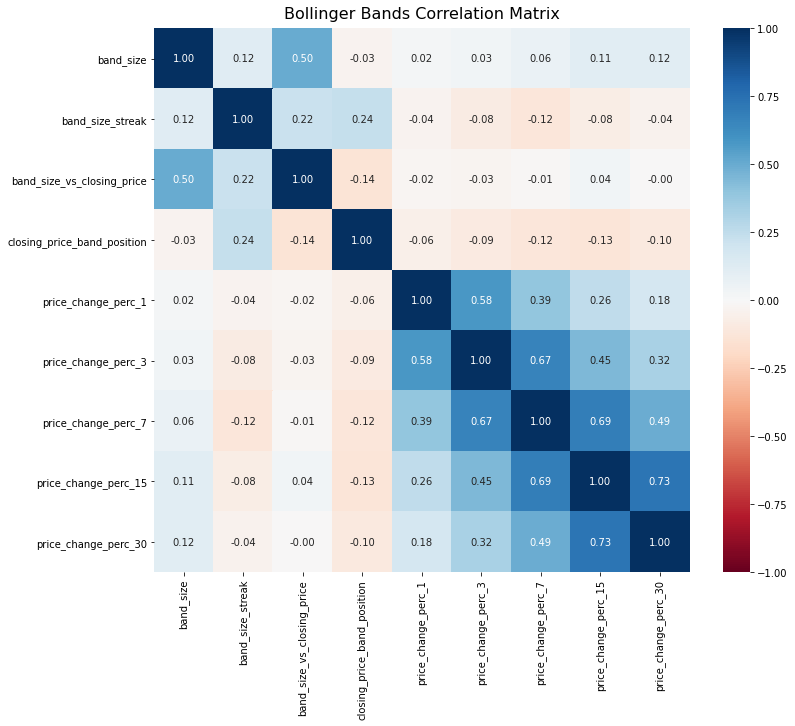

In [26]:
colinearity_subset(df=population_df[cols_bbands[1:] + cols_volume[1:]],
                   title='Bollinger Bands Correlation Matrix'
                  )

##### Price Band Position vs. 7 Day Change in Price

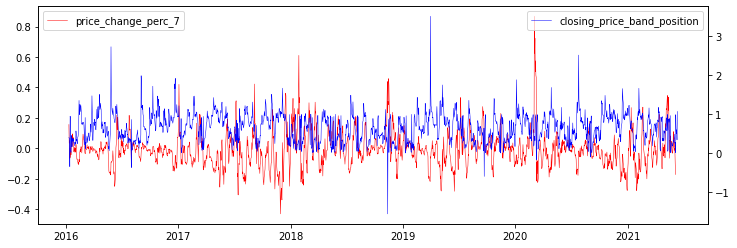

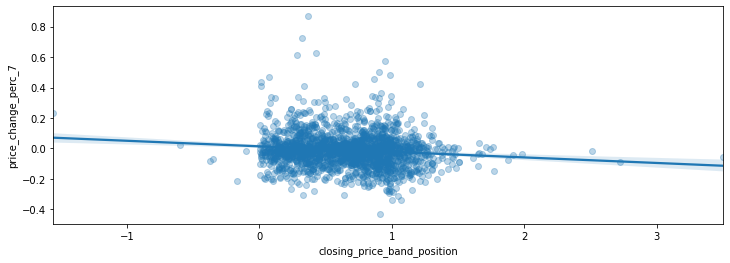

In [27]:
line_and_scatter(population_df, 'price_change_perc_7', 'closing_price_band_position')

#### Ichimoku Cloud Correlation

The Ichimoku Cloud is a set of indicators that attempt to show dynamic support and resistance levels, momentum, and trend direction. There are 5 key metrics that make up the Ichimoku Cloud:

- Tenkan Sen (Coversion Line) - Average of the low and high prices for prior N periods (for crypto, typically N = 20)
- Kijun Sen (Base Line) - Average of the low and high prices for prior N periods (for crypto, typically N = 60)
- Leading Span A - Average of Tenkan and Kijun, shifted forward N periods (for crypto, typically N = 30)
- Leading Span B - Average of the low and high prices for prior N periods, shifted forward M periods (for crypto, typically N = 60, M = 30)
- Lagging Span - Closing price, shifted back N periods, not used in this analysis (for crypto, typically N = 30)

As you can see, the Ichimoku indicators are built entirely using historical price information. These indicators serve as reference points, and traders pay particular attention when indicators cross. For example, the area between Leading Span A and Leading Span B is referred to as the cloud. When Span A is above Span B, the cloud is colored green, a bullish signal. When the lines cross, the cloud is colored red, and this is considered a bearish signal. When the Tenkan Sen crossed the Kijun Sen and is on top, this is viewed as a bullish signal, as the faster moving average is now above the slower moving average, signaling positive momentum. From these historical indicators, I have calculated new features representing the relationships between the different indicators. For example, I calculate the magnitude to which Tenkan Sen is above or below Kijun Sen (t_over_k) and for how many periods either line has been on top (t_over_k_streak).

Surprisingly, no individual Ichimoku indicator posted a strong correlation with price changes over any timeframe. Even more surprising is the fact that the correlations calculated are negative. I would have expected that these indicators, which signal momentum and direction, would have had positive correlations with Bitcoin price movement in future periods. Perhaps the volatility of Bitcoin is enough to destroy such correlation. Perhaps a more stable asset would return higher correlations with positive values. The fact that no single indicator does show promise for predicting price movement on its own points to the necessity of a model like random forest.

,t_over_k,t_over_k_streak,price_over_t,price_over_t_streak,price_over_k,price_over_k_streak,price_over_cloud_top,price_over_cloud_bottom,cloud_over_price,span_a_over_b,future_cloud_over_price,future_span_a_over_b,price_change_perc_1,price_change_perc_3,price_change_perc_7,price_change_perc_15,price_change_perc_30
t_over_k,1.000000,0.518563,0.175564,0.394408,0.778888,0.613912,0.776424,0.738596,-0.299562,0.253509,-0.059258,0.599448,-0.023636,-0.042123,-0.061074,-0.078190,-0.087952
t_over_k_streak,0.518563,1.000000,0.079902,0.287927,0.378900,0.759400,0.502301,0.481184,-0.234940,0.363861,-0.076550,0.572213,-0.024814,-0.043065,-0.065108,-0.091656,-0.081688
price_over_t,0.175564,0.079902,1.000000,0.507418,0.749835,0.267490,0.431207,0.417071,-0.225761,0.159907,-0.184560,0.168883,-0.040696,-0.083574,-0.119484,-0.155391,-0.148033
price_over_t_streak,0.394408,0.287927,0.507418,1.000000,0.583954,0.470902,0.489496,0.456140,-0.304216,0.165436,-0.277607,0.287194,-0.027354,-0.047110,-0.050177,-0.064901,-0.100423
price_over_k,0.778888,0.378900,0.749835,0.583954,1.000000,0.567812,0.798845,0.764849,-0.339557,0.269796,-0.153043,0.501213,-0.042669,-0.081353,-0.117031,-0.153525,-0.154999
price_over_k_streak,0.613912,0.759400,0.267490,0.470902,0.567812,1.000000,0.629100,0.612294,-0.277454,0.370887,-0.093150,0.631553,-0.021324,-0.032522,-0.045873,-0.068804,-0.080563
price_over_cloud_top,0.776424,0.502301,0.431207,0.489496,0.798845,0.629100,1.000000,0.953405,-0.421560,0.441390,-0.115789,0.634928,-0.034347,-0.061003,-0.084798,-0.103763,-0.089631
price_over_cloud_bottom,0.738596,0.481184,0.417071,0.456140,0.764849,0.612294,0.953405,1.000000,-0.205484,0.557042,0.000205,0.673974,-0.028957,-0.048146,-0.061301,-0.069810,-0.053759
cloud_over_price,-0.299562,-0.234940,-0.225761,-0.304216,-0.339557,-0.277454,-0.421560,-0.205484,1.000000,-0.123179,0.534239,-0.225216,0.015113,0.036792,0.069458,0.111271,0.123468
span_a_over_b,0.253509,0.363861,0.159907,0.165436,0.269796,0.370887,0.441390,0.557042,-0.123179,1.000000,-0.024360,0.753369,-0.022959,-0.037446,-0.053288,-0.076693,-0.096371


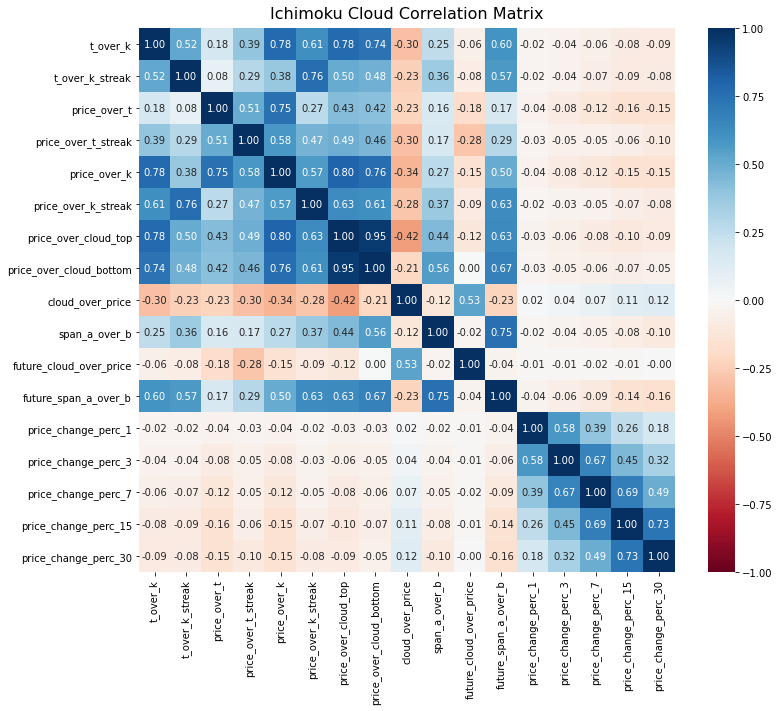

In [28]:
colinearity_subset(df=population_df[cols_ichimoku[1:] + cols_volume[1:]], 
                   title='Ichimoku Cloud Correlation Matrix'
                  )

##### Tenkan Sen Over Kijun Sen vs. 7 Day Change in Price

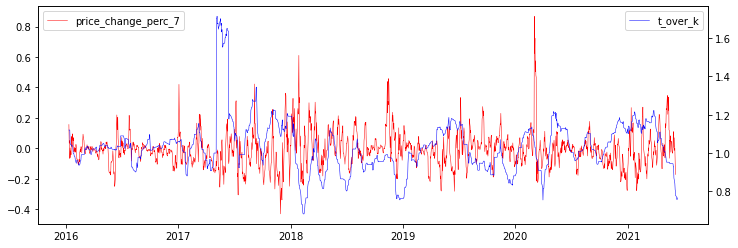

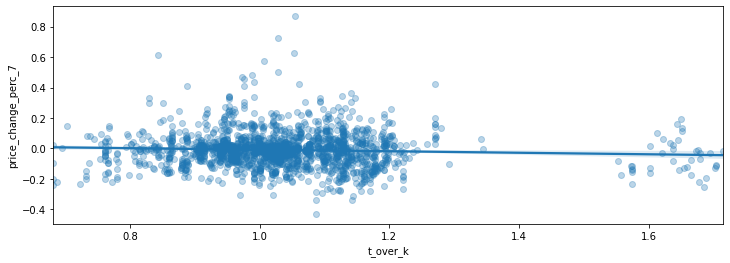

In [29]:
line_and_scatter(population_df, 'price_change_perc_7', 't_over_k')

##### Future Span A Over Span B (Cloud Orientation) vs. 7 Day Change in Price

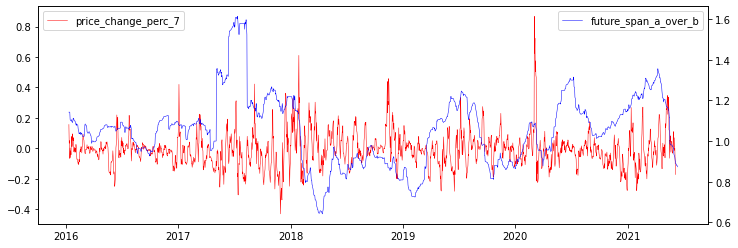

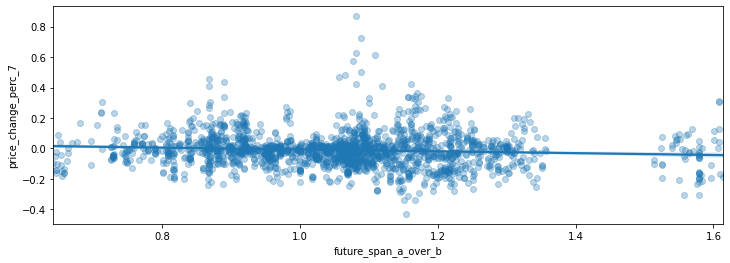

In [30]:
line_and_scatter(population_df, 'price_change_perc_7', 'future_span_a_over_b')

#### MACD Correlation

MACD (Moving Average Convergence Divergence) is calculated by subtracting the 26 period EMA (exponential moving average) from the 12 period EMA. The signal line, a 9 period EMA of the MACD itself, is used as a comparison. It is typical for traders to use the crosses of these two lines as bullish (MACD over signal) or bearish signals. It is somewhat similar to a comparison of the Tenkan Sen (Converstion Line) and the Kijun Sen (Base Line) from the Ichimoku indicators discussed above. When the faster moving line (MACD) is above the slower moving line (signal), it indicates upward momentum, a signal to buy. When the reverse occurs, traders view it as a sell signal. Again, as with the other indicators we have explored, there exists very little correlation between MACD related measures and future price changes. I'm sensing a pattern.

,macd,signal,histogram,macd_over_signal,macd_over_signal_streak,histogram_streak,hist_magnitude,price_change_perc_1,price_change_perc_3,price_change_perc_7,price_change_perc_15,price_change_perc_30
macd,1.000000,0.963242,0.345089,0.002240,0.225210,-0.049169,0.171322,-0.016058,-0.021902,-0.024816,-0.039401,-0.054842
signal,0.963242,1.000000,0.080272,-0.002798,0.136447,-0.113827,0.034369,-0.009214,-0.015532,-0.024153,-0.046825,-0.050699
histogram,0.345089,0.080272,1.000000,0.018085,0.358921,0.215252,0.515581,-0.027486,-0.027314,-0.008594,0.012149,-0.023919
macd_over_signal,0.002240,-0.002798,0.018085,1.000000,0.021932,-0.000636,0.034335,-0.016391,-0.033848,0.020885,0.021432,0.024341
macd_over_signal_streak,0.225210,0.136447,0.358921,0.021932,1.000000,-0.056355,0.600407,-0.050197,-0.077070,-0.105909,-0.101098,-0.042958
histogram_streak,-0.049169,-0.113827,0.215252,-0.000636,-0.056355,1.000000,0.336804,-0.035894,-0.047787,-0.035582,-0.064293,-0.038841
hist_magnitude,0.171322,0.034369,0.515581,0.034335,0.600407,0.336804,1.000000,-0.060015,-0.096686,-0.115997,-0.119106,-0.049999
price_change_perc_1,-0.016058,-0.009214,-0.027486,-0.016391,-0.050197,-0.035894,-0.060015,1.000000,0.582424,0.394549,0.257462,0.177793
price_change_perc_3,-0.021902,-0.015532,-0.027314,-0.033848,-0.077070,-0.047787,-0.096686,0.582424,1.000000,0.667728,0.450965,0.321716
price_change_perc_7,-0.024816,-0.024153,-0.008594,0.020885,-0.105909,-0.035582,-0.115997,0.394549,0.667728,1.000000,0.687716,0.492264


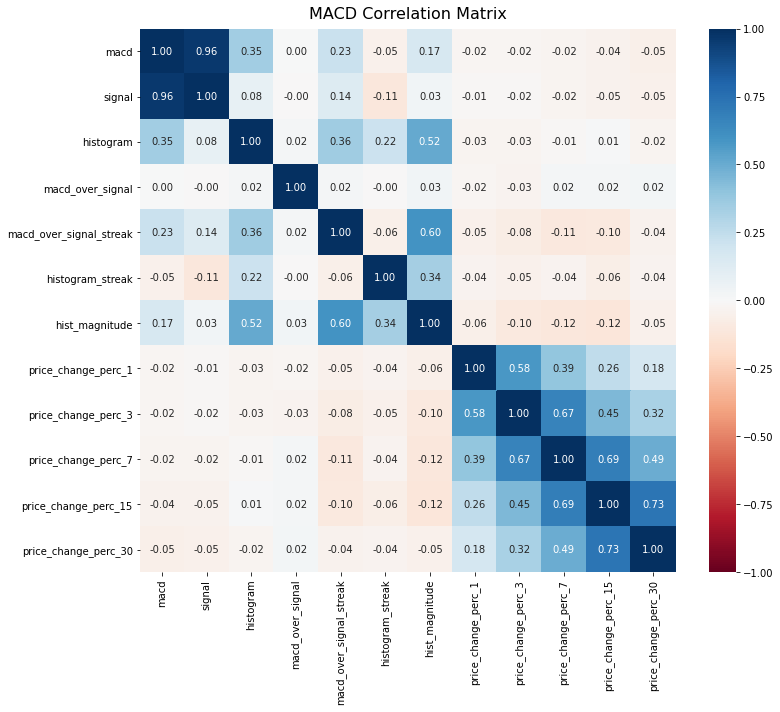

In [31]:
colinearity_subset(df=population_df[cols_macd[1:] + cols_volume[1:]],
                   title='MACD Correlation Matrix'
                  )

##### MACD Over Signal Streak vs. 7 Day Change in Price
Note: Streaks are above zero when MACD > Signal and below zero when Signal > MACD.

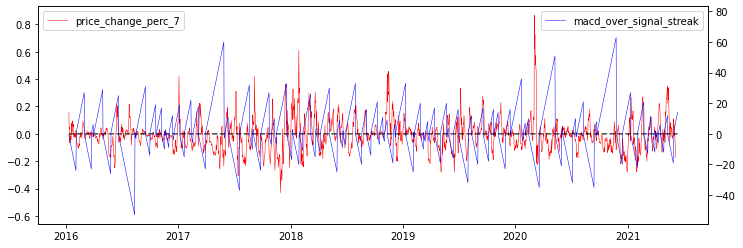

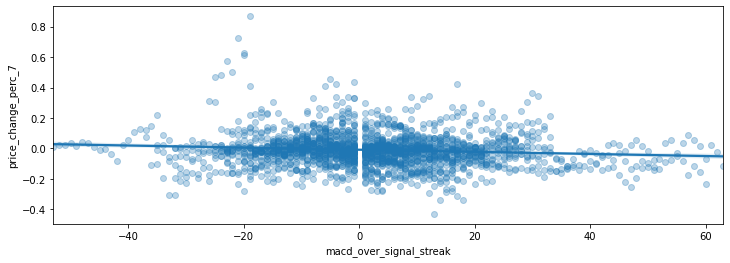

In [32]:
line_and_scatter(population_df, 'price_change_perc_7', 'macd_over_signal_streak', align=True)

#### On-Chain Metris Correlation

Finally! Some correlation! It feels odd to celebrate a 50% correlation (and only 25% on a 7 day timeframe), but beggars can't be choosers. On-chain metrics are indicators that capture blockchain related activity, as opposed to the price based indicators I have described so far. Some key on-chain metris include:

- Net Unrealized Profit and Loss (NUPL) - The difference between Relative Unrealized Profit and Relative Unrealized Loss. It can also be calculated by subtracting Realized Capitalization from Market Capitalization. Realized Capitalization refers to the value of a coin the last time it was traded. So, in effect, NUPL is a measure of how much price has changed since the asset has been held. When NUPL is very high, traders are being greedy and holding onto paper profits, hoping for even more. NUPL is therefore considered a measure of market sentiment.
- Stock-to-Flow Deflection (STFD) - The ratio between the current price of an asset and its Stock-to-Flow Ratio. Stock-to-Flow is a popular valuation model that assumes scarcity in an asset drives value. It has been historically very predictive of the price of Bitcoin.
- Market Cap to Themo Cap Ratio - This is used to assess if an asset's price is trading at a premium vs. the total security spend by miners, adjusted for increasing supply over time. Ignoring the confusing definition, parabolic spikes in market cap to thermo cap have been known to signal market tops.
- Hash Rate - The measuring unit of the processing power of the Bitcoin network. The Bitcoin network must make intensive mathematical operations for security purposes.
- Mining Difficulty - The current estimated number of hashes required to mine a new block.
- Net Transfer Volume - The difference of volume (in this case of Bitcoin) flowing into and out of exchanges (like Coinbase, for example). As coins are flowing off of exchanges, it is presumed that these coins will be held, and not sold. Substantial inflow to exchanges may preempt sell offs.
- Address Metrics - The number of new addresses, active addresses, and their rates of change are common metrics of activity.

,nupl,stfd,market_to_thermo,active_addresses,new_addresses,new_over_active,new_over_active_30,active_change_perc_30,transactions,transactions_30,...,mining_difficulty_norm,transaction_fees,transaction_fees_30,net_transfer_volume,net_transfer_volume_30,price_change_perc_1,price_change_perc_3,price_change_perc_7,price_change_perc_15,price_change_perc_30
nupl,1.000000,0.217153,0.588337,0.483306,0.474516,-0.011963,0.017461,0.058777,0.140771,0.183567,...,-0.584405,0.532630,0.555407,0.020316,0.026129,-0.018120,-0.023087,-0.023908,-0.027845,-0.013628
stfd,0.217153,1.000000,0.495293,0.052627,0.012380,-0.121457,-0.235833,0.051485,-0.062779,-0.061769,...,-0.279772,0.244807,0.244250,0.085422,0.323047,0.078031,0.143823,0.218078,0.319401,0.448399
market_to_thermo,0.588337,0.495293,1.000000,0.638210,0.563452,-0.135929,-0.218979,0.024262,0.156011,0.218927,...,-0.407168,0.521210,0.541461,0.082365,0.270851,0.022574,0.046044,0.080564,0.133822,0.210245
active_addresses,0.483306,0.052627,0.638210,1.000000,0.935968,0.073724,-0.028875,0.289731,0.623062,0.599139,...,0.094934,0.267566,0.268674,0.000055,-0.099212,-0.022769,-0.033415,-0.013512,0.000288,0.025093
new_addresses,0.474516,0.012380,0.563452,0.935968,1.000000,0.264360,0.211837,0.337444,0.755286,0.670014,...,0.138783,0.306157,0.254305,0.003491,-0.120721,-0.035621,-0.051630,-0.041854,-0.048364,-0.032254
new_over_active,-0.011963,-0.121457,-0.135929,0.073724,0.264360,1.000000,0.470096,0.450375,0.402647,0.126950,...,0.076118,0.074419,-0.029219,0.076292,-0.046879,-0.026268,-0.044550,-0.054230,-0.087811,-0.103515
new_over_active_30,0.017461,-0.235833,-0.218979,-0.028875,0.211837,0.470096,1.000000,0.324889,0.437858,0.389623,...,0.157510,0.272237,0.122376,0.017312,-0.035915,-0.043363,-0.081718,-0.123257,-0.178777,-0.205082
active_change_perc_30,0.058777,0.051485,0.024262,0.289731,0.337444,0.450375,0.324889,1.000000,0.397833,0.101598,...,0.003733,0.037957,-0.053027,0.041817,-0.077665,-0.018002,-0.047623,-0.028260,-0.013954,-0.013122
transactions,0.140771,-0.062779,0.156011,0.623062,0.755286,0.402647,0.437858,0.397833,1.000000,0.831998,...,0.334194,0.107432,0.027909,0.013752,-0.102691,-0.044271,-0.061032,-0.047007,-0.054918,-0.056064
transactions_30,0.183567,-0.061769,0.218927,0.599139,0.670014,0.126950,0.389623,0.101598,0.831998,1.000000,...,0.389603,0.223346,0.150269,-0.001752,-0.046602,-0.015449,-0.027522,-0.034853,-0.053758,-0.061710


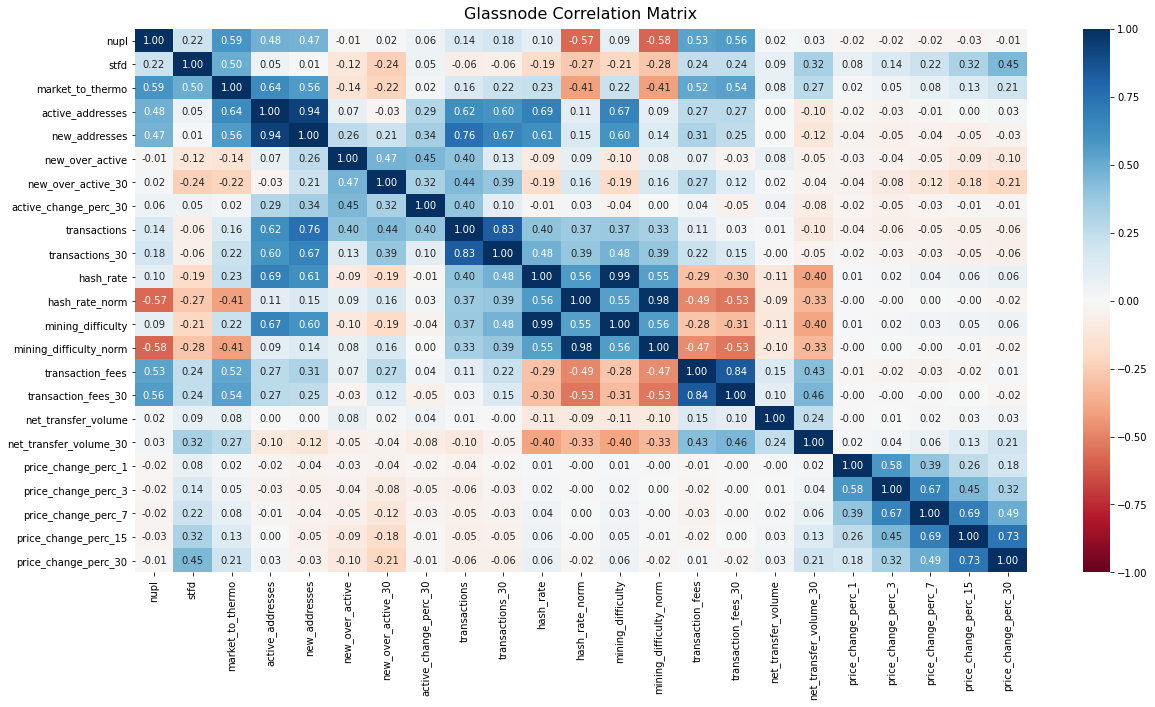

In [33]:
colinearity_subset(df=population_df[cols_glassnode[1:] + cols_volume[1:]],
                   title='Glassnode Correlation Matrix',
                   figsize=(20,10)
                  )

##### Stock to Flow Deflection Ratio (STFD) vs. 7 Day Change in Price

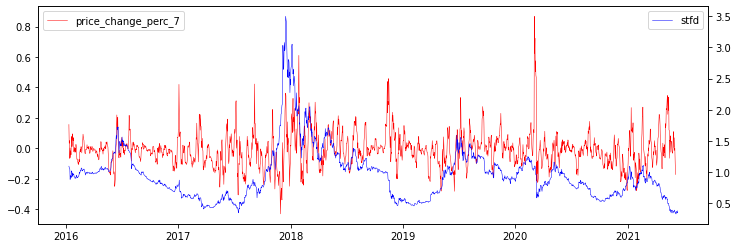

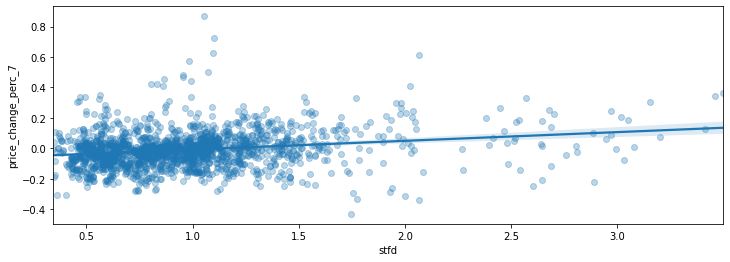

In [34]:
line_and_scatter(population_df, 'price_change_perc_7', 'stfd')

##### Net Transfer Volume 30 Day Avg vs. 7 Day Change in Price

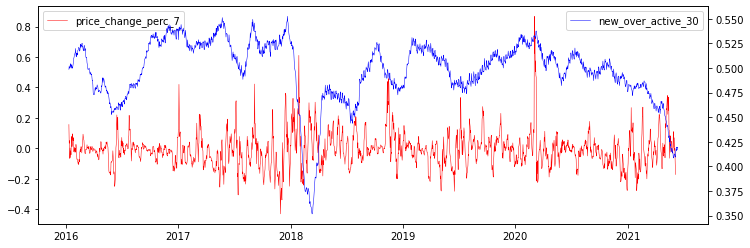

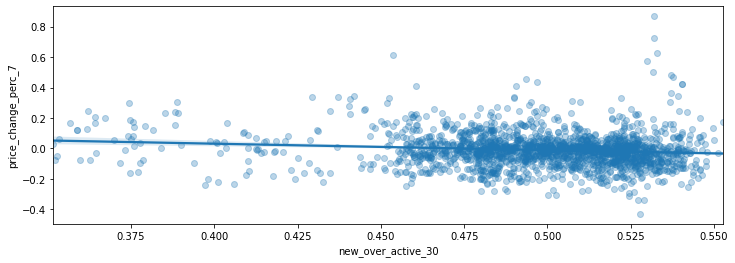

In [35]:
line_and_scatter(population_df, 'price_change_perc_7', 'new_over_active_30')

#### RSI Correlation

RSI metrics do not appear to correlate strongly with future price changes, but it makes sense that the correlations would be negative. When RSI is above 70%, an asset is considered "overbought," meaning that price may be inflated. When RSI drops below 30%, the asset is considered "oversold," implying that the price may be a bargain at current prices. The "over_under_streak" metric below tracks the number of consecutive periods that Bitcoin is overbought or oversold.

,rsi,rsi_streak,over_under_streak,price_change_perc_1,price_change_perc_3,price_change_perc_7,price_change_perc_15,price_change_perc_30
rsi,1.000000,0.447701,0.626116,-0.073393,-0.110629,-0.135533,-0.159501,-0.135395
rsi_streak,0.447701,1.000000,0.196393,-0.073583,-0.088874,-0.084403,-0.097201,-0.082461
over_under_streak,0.626116,0.196393,1.000000,-0.006825,0.002786,-0.004643,-0.011352,-0.032361
price_change_perc_1,-0.073393,-0.073583,-0.006825,1.000000,0.582424,0.394549,0.257462,0.177793
price_change_perc_3,-0.110629,-0.088874,0.002786,0.582424,1.000000,0.667728,0.450965,0.321716
price_change_perc_7,-0.135533,-0.084403,-0.004643,0.394549,0.667728,1.000000,0.687716,0.492264
price_change_perc_15,-0.159501,-0.097201,-0.011352,0.257462,0.450965,0.687716,1.000000,0.732807
price_change_perc_30,-0.135395,-0.082461,-0.032361,0.177793,0.321716,0.492264,0.732807,1.000000


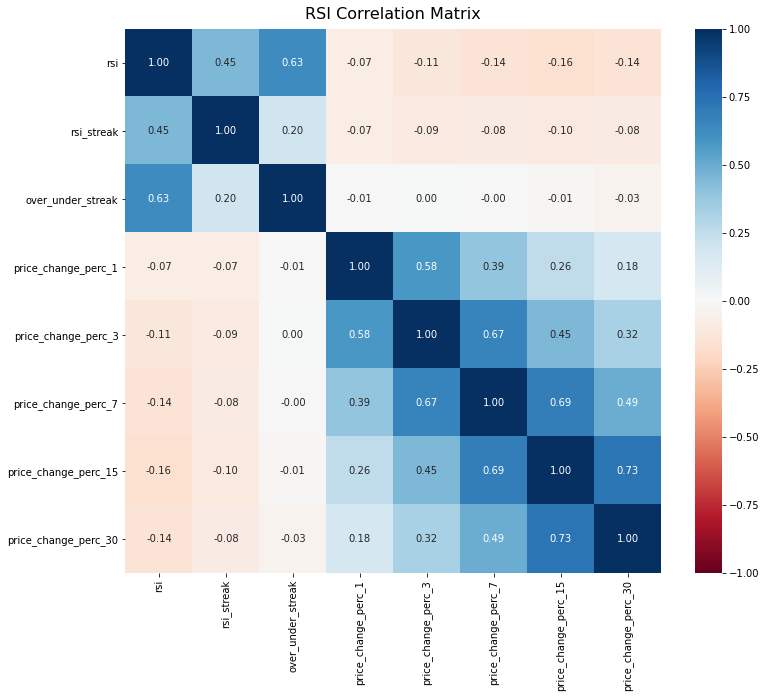

In [36]:
colinearity_subset(df=population_df[list(rsi_df.columns) + cols_volume[1:]],
                   title='RSI Correlation Matrix'
                  )

#### Regression Correlation

I've calculated the slope of the regression line for a few key indicators (Closing Price, Volume, MACD, RSI) in order to search for correlations between the trend of these indicators and future price movements. There are no correlations of note here, especially on the lower timeframes. This highlights the volatility in the cryptocurrency market. The prior week's price performance, in a vacuum, does not tell us much after next week's price performance. The same appears to be true for volume, MACD, and RSI.

,close_reg_norm3,close_reg_norm7,close_reg_norm15,close_reg_norm30,close_reg_norm60,close_reg_norm120,volume_reg_norm3,volume_reg_norm7,volume_reg_norm15,volume_reg_norm30,...,rsi_reg_norm7,rsi_reg_norm15,rsi_reg_norm30,rsi_reg_norm60,rsi_reg_norm120,price_change_perc_1,price_change_perc_3,price_change_perc_7,price_change_perc_15,price_change_perc_30
close_reg_norm3,1.000000,0.496671,0.215413,0.114500,0.055136,0.051552,-0.060770,-0.034423,-0.022056,0.007574,...,0.215510,0.106234,0.091534,0.027555,0.045613,-0.001380,-0.030415,-0.046422,-0.045709,-0.040085
close_reg_norm7,0.496671,1.000000,0.598618,0.307776,0.141452,0.105162,0.014732,-0.037892,-0.055379,0.001194,...,0.736105,0.449983,0.290206,0.125933,0.120858,-0.039816,-0.065565,-0.060900,-0.091724,-0.052487
close_reg_norm15,0.215413,0.598618,1.000000,0.669711,0.329344,0.202447,0.026634,0.071194,0.028551,0.041230,...,0.243306,0.686828,0.595116,0.337119,0.259789,-0.031592,-0.049633,-0.076588,-0.099684,-0.050134
close_reg_norm30,0.114500,0.307776,0.669711,1.000000,0.666543,0.384337,0.020538,0.061215,0.132646,0.156914,...,-0.122484,0.062983,0.570046,0.577957,0.448865,-0.032214,-0.047854,-0.057629,-0.047543,-0.042508
close_reg_norm60,0.055136,0.141452,0.329344,0.666543,1.000000,0.701712,0.008187,0.020343,0.066153,0.148847,...,-0.184411,-0.221453,-0.125828,0.380387,0.537698,-0.016771,-0.027214,-0.038038,-0.041921,-0.050163
close_reg_norm120,0.051552,0.105162,0.202447,0.384337,0.701712,1.000000,0.005017,0.010342,0.030629,0.074220,...,-0.094237,-0.138703,-0.179873,-0.191020,0.145573,-0.019901,-0.034449,-0.048698,-0.065777,-0.074105
volume_reg_norm3,-0.060770,0.014732,0.026634,0.020538,0.008187,0.005017,1.000000,0.234428,0.007102,-0.038649,...,0.020439,0.020796,0.029839,0.015559,0.014147,-0.006134,-0.019937,-0.013132,-0.016263,-0.008305
volume_reg_norm7,-0.034423,-0.037892,0.071194,0.061215,0.020343,0.010342,0.234428,1.000000,0.423650,0.081400,...,-0.075715,0.039442,0.086454,0.042422,0.035592,-0.003465,-0.001212,0.000615,-0.028184,0.000327
volume_reg_norm15,-0.022056,-0.055379,0.028551,0.132646,0.066153,0.030629,0.007102,0.423650,1.000000,0.437020,...,-0.136837,-0.085004,0.119894,0.098998,0.089618,-0.018790,-0.031083,-0.063302,-0.043894,-0.026756
volume_reg_norm30,0.007574,0.001194,0.041230,0.156914,0.148847,0.074220,-0.038649,0.081400,0.437020,1.000000,...,-0.076276,-0.119325,-0.006237,0.134407,0.154034,-0.018435,-0.026775,-0.028545,-0.006498,-0.076878


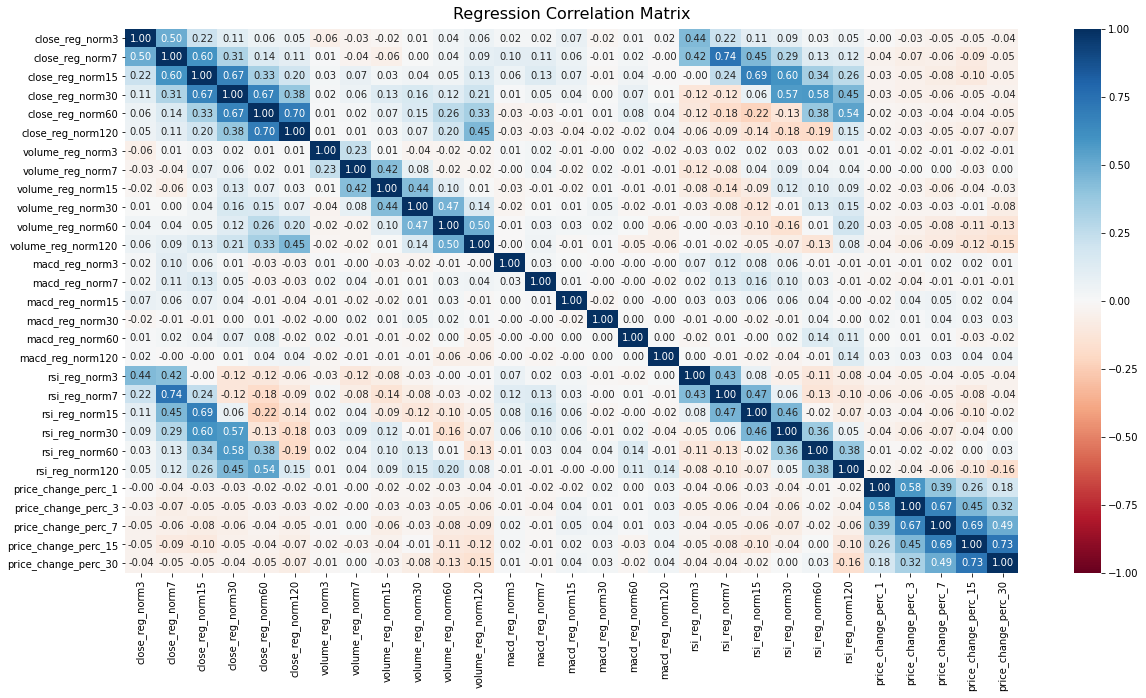

In [37]:
colinearity_subset(df=population_df[cols_divergence[1:] + cols_volume[1:]],
                   title='Regression Correlation Matrix',
                   figsize=(20,10)
                  )

##### Past 7 Days Price Regression Slope vs. Next 7 Days Change in Price

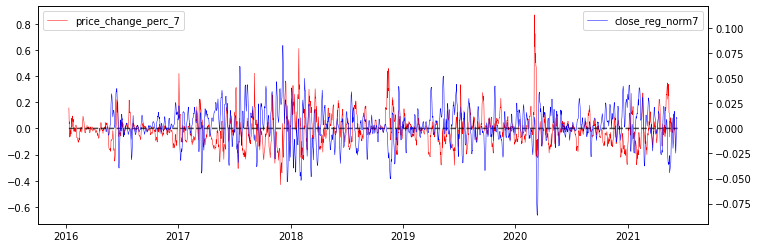

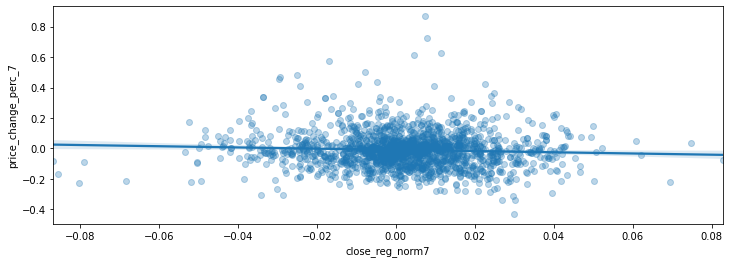

In [38]:
line_and_scatter(population_df, 'price_change_perc_7', 'close_reg_norm7', align=True)

##### Past 7 Days RSI Regression Slope vs. Next 7 Days Change in Price

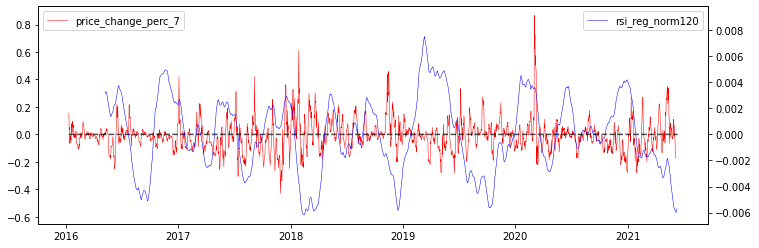

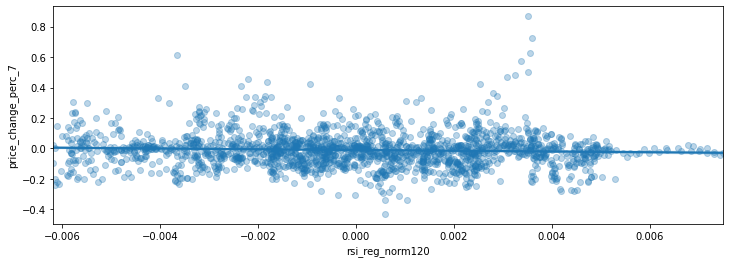

In [39]:
line_and_scatter(population_df, 'price_change_perc_7', 'rsi_reg_norm120', align=True)

#### Percent Change in Price Distribution

I was surprised to find that the mean price change was negative over any period I examined (1 day, 3 days, 7 days, 15 days, 30 days). Meanwhile, the price of Bitcoin has increased more than 6000% over the time covered by my population for this analysis. This, of course, points to massive spikes in price in parabolic movements, followed by longer periods of price decline. This is visible in the price charts, but it was still surprising to see that, for example, the mean price change over any 30 day period was a 6.17% decline.

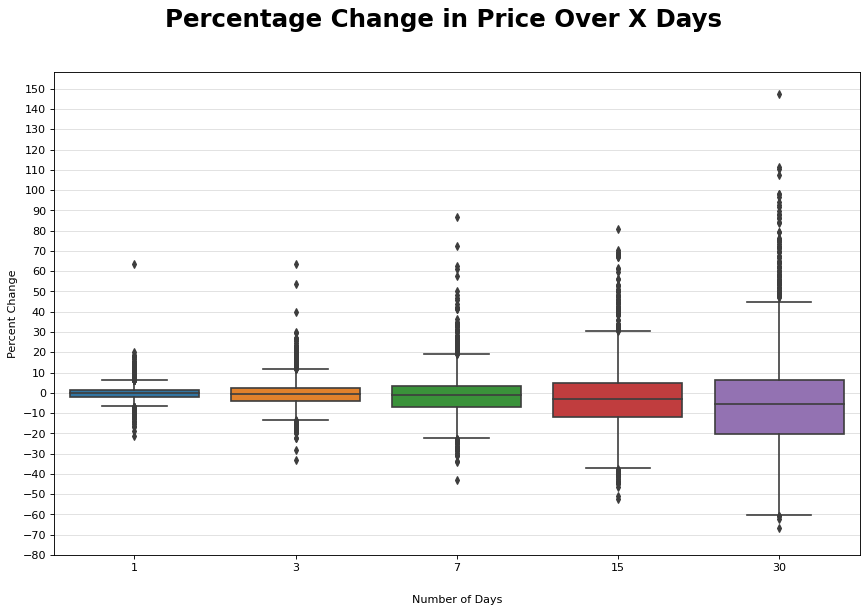

In [40]:
# Show boxplot of percentage changes by number of days in the population
perc_change_df = population_df[price_change_perc_cols].melt(var_name='Number of Days', value_name='Percent Change')
perc_change_df['Percent Change'] = perc_change_df['Percent Change'] * 100.0

min_y = floor(perc_change_df['Percent Change'].min() / 10.0 ) * 10.0
max_y = ceil(perc_change_df['Percent Change'].max() / 10.0) * 10.0

plt.figure(figsize=(13,8), dpi= 80)
plt.suptitle('Percentage Change in Price Over X Days', fontsize=22, fontweight='bold')
ax = sns.boxplot(x='Number of Days', y='Percent Change', data=perc_change_df)
plt.yticks(np.arange(min_y - 10.0, max_y + 10.0, 10))
ax.set_xlabel(xlabel = 'Number of Days', labelpad=20)
ax.set(xticklabels=[1, 3, 7, 15, 30])
ax.set_axisbelow(True)
ax.yaxis.grid(alpha=0.4);

In [41]:
# Describe the distribution of percentage changes for different periods
perc_change = population_df[price_change_perc_cols].describe().T
format_dict = {'count' : '{:0.0f}',
               'mean' : '{:.2%}',
               'std' : '{:.2%}',
               'min' : '{:.2%}',
               '25%' : '{:.2%}',
               '50%' : '{:.2%}',
               '75%' : '{:.2%}',
               'max' : '{:.2%}'
              }
cm = sns.light_palette("green", as_cmap=True)

perc_change.style.format(format_dict)

,count,mean,std,min,25%,50%,75%,max
price_change_perc_1,1980,-0.14%,4.22%,-21.38%,-1.92%,-0.26%,1.33%,63.43%
price_change_perc_3,1978,-0.43%,7.08%,-33.04%,-4.04%,-0.71%,2.33%,63.36%
price_change_perc_7,1974,-1.00%,11.08%,-43.05%,-6.98%,-1.19%,3.49%,86.74%
price_change_perc_15,1966,-2.08%,16.34%,-52.56%,-11.88%,-2.84%,5.07%,80.73%
price_change_perc_30,1951,-3.97%,24.18%,-66.80%,-20.30%,-5.74%,6.47%,147.63%


#### Pickling Checkpoint - Population Data

In [42]:
# Add prediction/classification columns for each timeframe (Sell, Buy)
for period in price_change_periods:
    price_change = population_df['price_change_perc_' + str(period)]
    population_df['prediction_' + str(period)] = np.where(price_change < 0.0, 'Sell', 'Buy')                                                       

In [43]:
# Pickle the cleaned and organized data
root = str(Path(".")) +'/random_forest_pickles'

In [27]:
with open(root + '/pickle_rf_population.pickle', 'wb') as to_write:
    pickle.dump(population_df, to_write)

In [28]:
# Open pickled population_df
with open(root + '/pickle_rf_population.pickle', 'rb') as read_file:
    population_df = pickle.load(read_file)

### Step 6: Feature Reduction

The process of reducing features to an appropriate level was tricky and time consuming. Random forest models, while more accurate than many other models, take longer to run. Due to a lack of speed, I did not have the luxury of testing every combination of features to find out which combination led to the best results. Instead, I decided to leverage feature importance calculations in an attempt to reduce the workload. These were the steps I took to settle on feature sets for additional refinement:

- First, I came up with a set of features that I believed intuitively made the most sense for price movement prediction. This left me with two feature sets: (1) all features in the population, and (2) a a set of "intuitive features."
- Next, I ran both feature sets through **sequential forward selection** and **sequential backward selection**. Sequential forward selection works by first finding the single feature that provides the best predictions, as determined by the model accuracy score. I then loop through the remaining features to find the second feature that will produce the best accuracy score. This process is repeated until all features are put in order. For sequential backward selection, I began with all features in a random forest model. I then removed the feature with the lowest feature importance and reran the model. This process was repeated until all features were ordered.
- I then took the top 10 feature combinations from sequential forward and backward selection. Using a Counter, I determined the features that appeared most frequently in the highest scoring combinations. I took these features and then, through brute force, tested the accuracy of each and every combination of feautes (using the **all_combinations** function defined below). I performed this step for the "all features" and "intuitive features" feature sets. This gave me two final feature sets to use as the starting place for random forest classifier models.
- I also combined the top features lists that resulted from sequential forward and backward selection for "all features" and "intuitive features." I ran this combined list of features through the same process, doing another sequential feature selection and brute force combination testing. This provided me with a third final feature set I am calling the "combined features," as includes some of the features distilled from the "intuitive features" and some distilled from "all features."

In [44]:
# Parameters
n = '7' # periods to use for prediction (e.g. price change over n days)
cutoff = datetime(2020, 1, 1).date() # cutoff date for train/test split
rf_classifier = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='gini', random_state=0)

In [45]:
def date_train_test_split(data, n, cutoff):
    """
    Accept data, period for prediction (n), and a cutoff date.
    Return train test split dataframes.
    """
    train_data = data[data['date'] < cutoff]
    test_data = data[data['date'] >= cutoff]

    y_train = train_data['prediction_' + n]
    x_train = train_data.drop(columns=['date', 'prediction_' + n, 'price_change_perc_' + n])
    y_test = test_data['prediction_' + n]
    x_test = test_data.drop(columns=['date', 'prediction_' + n, 'price_change_perc_' + n])
    
    return x_train, y_train, x_test, y_test


In [46]:
def sequential_backward(population_df, n, cutoff, test_columns):
    """
    Accepts features (columns) with a population and returns them in sequential order based on random forest
    classifier accuracy score. The function begins by scoring a model with all features. It then loops through 
    all remaining features and removes the feature with the lowest feature importance score and repeats until all
    features are ordered in a list.
    """

    other_columns = ['date', 'prediction_' + n, 'price_change_perc_' + n]

    rf_classifier = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='gini', random_state=0)
    feature_combos = pd.DataFrame()

    backward_order = []

    while test_columns:
        cols = other_columns + test_columns
        data = population_df[cols].copy()
        data.dropna(inplace=True)

        x_train, y_train, x_test, y_test = date_train_test_split(data, n, cutoff)

        rf_classifier.fit(x_train, y_train)
        y_pred = rf_classifier.predict(x_test)
        score = accuracy_score(y_test, y_pred, normalize = True)

        test_instance = {'combo' : [cols], 'score' : score, 'length' : len(test_columns)}
        feature_combos = feature_combos.append(test_instance, ignore_index=True)

        feature_importance = pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
        remove = feature_importance.index[-1]

        test_columns.remove(remove)
        backward_order.extend([remove])

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    
    return backward_order, sorted_combos

In [1028]:
def sequential_forward(population_df, n, cutoff, test_columns):
    """
    Accepts features (columns) with a population and returns them in sequential order based on random forest
    classifier accuracy score. The function finds the single feature with the greatest feature importance score.
    It then loops through remaining features and adds the feature with the greatest feature importance score and repeats
    until all features are ordered in a list.
    """
    
    other_columns = ['date', 'prediction_' + n, 'price_change_perc_' + n]

    rf_classifier = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='gini', random_state=0)
    feature_combos = pd.DataFrame()

    forward_order = []
    i = 1

    while test_columns:
        for col in test_columns:
            cols = other_columns + forward_order + [col]
            data = population_df[cols].copy()
            data.dropna(inplace=True)

            x_train, y_train, x_test, y_test = date_train_test_split(data, n, cutoff)

            rf_classifier.fit(x_train, y_train)
            y_pred = rf_classifier.predict(x_test)

            score = accuracy_score(y_test, y_pred, normalize = True)

            test_instance = {'combo' : [cols], 'score' : score, 'length' : i}
            feature_combos = feature_combos.append(test_instance, ignore_index=True)

        remove = feature_combos[feature_combos['length']==i].sort_values('score', ascending=False).reset_index().loc[0,'combo'][0][-1]

        test_columns.remove(remove)
        forward_order.extend([remove])
        i += 1

    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    
    return forward_order, sorted_combos

In [1095]:
def all_combinations(population_df, n, cutoff, test_columns, combo_min, combo_max):
    """
    Accepts features (columns) with a population and returns a dataframe with all combinations of the features
    in a given range (e.g. 5 - 10 features). The dataframe is sorted by the accuracy score for each feature 
    combination.
    """
    
    other_columns = ['date', 'prediction_' + n, 'price_change_perc_' + n]

    rf_classifier = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='gini', random_state=0)
    feature_combos = pd.DataFrame()

    for i in range(combo_min, combo_max + 1, 1):
        print(i)
        for combo in combinations(test_columns, i):  # 2 for pairs, 3 for triplets, etc
            cols = other_columns + list(combo)
            data = population_df[cols].copy()
            data.dropna(inplace=True)

            x_train, y_train, x_test, y_test = date_train_test_split(data, n, cutoff)

            rf_classifier.fit(x_train, y_train)
            y_pred = rf_classifier.predict(x_test)

            score = accuracy_score(y_test, y_pred, normalize = True)

            test_instance = {'combo' : [cols], 'score' : score}
            feature_combos = feature_combos.append(test_instance, ignore_index=True)
    
    sorted_combos = feature_combos.sort_values('score', ascending=False).reset_index()
    
    return sorted_combos

In [1050]:
def count_combine(forward_df, backward_df, top_n):
    """
    Accept dataframes returned by sequential_forward and sequential_backward. Count feature
    occurrences in the top n rows, ordered by accuracy score. Return combined list of features,
    removing duplicates.
    """
    forward_feature_list = []
    for combo in forward_df.loc[0:top_n, 'combo']:
        forward_feature_list.extend(combo[0][3:])

    
    backward_feature_list = []
    for combo in backward_df.loc[-1 * top_n:, 'combo']:
        backward_feature_list.extend(combo[0][3:])
    
    combined_feature_list = []
    
    for feature_list in [forward_feature_list, backward_feature_list]:
        counter = Counter(feature_list).most_common(10)
        top_10 = [x[0] for x in counter]
        combined_feature_list.extend(top_10)
    
    return list(set(combined_feature_list))

In [899]:
all_features = [x for x in list(population_df.columns) if ('prediction' not in x) & ('price_change' not in x)][1:]

In [954]:
intuitive_potential_features = ['stfd', 'market_to_thermo', 'nupl', 'new_over_active_30', 'transactions_30', 'transaction_fees_30',
                                'price_over_k_streak', 't_over_k', 'price_over_k', 'price_over_k_streak', 't_over_k_streak', 'price_over_t', 
                                'price_over_t_streak', 'price_over_cloud_bottom', 'cloud_over_price', 'price_over_cloud_top', 'span_a_over_b',
                                'future_cloud_over_price', 'future_span_a_over_b', 'close_reg_norm7', 'close_reg_norm15', 'close_reg_norm30',
                                'volume_reg_norm7', 'volume_reg_norm15', 'volume_reg_norm30', 'rsi', 'rsi_reg_norm7', 'rsi_reg_norm15', 
                                'rsi_reg_norm30', 'macd', 'macd_reg_norm7', 'macd_reg_norm15', 'macd_reg_norm30', 'macd_over_signal', 
                                'histogram_streak', 'rsi_streak', 'over_under_streak', 'band_size_vs_closing_price', 
                                'closing_price_band_position'
                               ]

In [1019]:
all_features_top_backward_forward = ['macd_reg_norm60', 'stfd', 'new_over_active_30', 'active_addresses', 'price_over_cloud_top', 
                                     'over_under_streak', 'mining_difficulty_norm', 'rsi_reg_norm120', 'net_transfer_volume_30', 
                                     'volume_reg_norm60', 't_over_k_streak', 'close_reg_norm120', 'market_to_thermo', 'close_reg_norm60', 
                                     'nupl', 'band_size_vs_closing_price', 'future_cloud_over_price', 'cloud_over_price', 
                                     'transaction_fees_30']

intuitive_top_backward_forward = ['volume_reg_norm7', 'stfd', 'new_over_active_30', 'price_over_cloud_top', 'transactions_30', 
                                  'macd_reg_norm30', 't_over_k_streak', 'span_a_over_b', 'price_over_k_streak', 'market_to_thermo', 
                                  'rsi_reg_norm7', 'future_cloud_over_price', 'cloud_over_price', 'price_over_cloud_bottom', 
                                  'price_over_k', 'transaction_fees_30']

combined_backward_forward = list(set(all_features_top_backward_forward[-10:]).union(set(intuitive_top_backward_forward[0:10])))

In [1038]:
combined_top_backward_forward = list(set(all_features_top_backward_forward + intuitive_top_backward_forward))

In [1062]:
combined_forward_order, combined_sorted_combos_forward = sequential_forward(population_df=population_df,
                                                                            n=n,
                                                                            cutoff=cutoff,
                                                                            test_columns=combined_top_backward_forward.copy())


In [1040]:
combined_backward_order, combined_sorted_combos_backward = sequential_backward(population_df=population_df,
                                                                               n=n,
                                                                               cutoff=cutoff,
                                                                               test_columns=combined_top_backward_forward.copy())


In [1096]:
combined_top_features = count_combine(forward_df=combined_sorted_combos_forward,
                                      backward_df=combined_sorted_combos_backward,
                                      top_n=10
                                     )

In [ ]:
combined_sorted_combos = all_combinations(population_df=population_df,
                                          n=n, 
                                          cutoff=cutoff,
                                          test_columns=combined_top_features, 
                                          combo_min=6, 
                                          combo_max=8)

In [47]:
intuitive_favorite = ['date', 'prediction_7', 'price_change_perc_7', 'stfd', 'new_over_active_30', 'transactions_30', 
                      't_over_k_streak', 'market_to_thermo', 'cloud_over_price', 'transaction_fees_30']

all_features_favorite = ['date', 'prediction_7', 'price_change_perc_7', 'stfd', 'mining_difficulty_norm', 'rsi_reg_norm120', 
                         't_over_k_streak', 'nupl', 'transaction_fees_30']

combined_favorite = ['date', 'prediction_7', 'price_change_perc_7', 'new_over_active_30', 'price_over_cloud_top', 
                     'mining_difficulty_norm', 'stfd', 'market_to_thermo', 'nupl', 'transaction_fees_30']

### Step 7: Parameter Tuning

For each set of features ("All," "Intuitive," "Combined"), I did two rounds of paramater tuning using the **optimal_parameters** function defined below. I began with lists of potential parameter values and ran through every combination of parameters in those lists. I then examined the top scoring combinations based on model accurary. I then refined the parameter options, dialing in closer to the optimal levels. I reran the optimal_parameters function a second time on these refined lists and once again examined the top combinations. Ultimately, I settled on a parameter set that maximized accuracy for each of the three models.

In [1005]:
def optimal_parameters(x_train, y_train, bootstrap=[True], max_depth=[None], max_features=['auto'],
                       min_samples_leaf=[1], min_samples_split=[2], n_estimators=[100]):
    """
    Accept parameter options in lists and return sorted dataframe of parameter combos and their accuracy scores.
    """
    
    parameter_combos = pd.DataFrame()
    
    for combo in product(bootstrap, max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators):
        rf_classifier = RandomForestClassifier(criterion='gini',
                                               random_state=0,
                                               bootstrap=combo[0],
                                               max_depth=combo[1],
                                               max_features=combo[2],
                                               min_samples_leaf=combo[3],
                                               min_samples_split=combo[4],
                                               n_estimators=combo[5]
                                              )

        rf_classifier.fit(x_train, y_train)
        y_pred = rf_classifier.predict(x_test)

        score = accuracy_score(y_test, y_pred, normalize = True)

        test_instance = {'combo' : combo, 'score' : score}
        parameter_combos = parameter_combos.append(test_instance, ignore_index=True)

    sorted_parameter_combos = parameter_combos.sort_values('score', ascending=False).reset_index()
    
    return sorted_parameter_combos

In [1114]:
# Complete parameter lists
bootstrap = [True, False]
max_depth = [None, 10, 25, 50, 100]
max_features = ['auto', 'sqrt', 'log2']
min_samples_leaf = [1, 5, 10, 15, 20, 50]
min_samples_split = [2, 5, 10, 15, 20, 50]
n_estimators = [100, 200, 300, 600]


data = population_df[combined_favorite].copy()
data.dropna(inplace=True)

x_train, y_train, x_test, y_test = date_train_test_split(data, n, cutoff)

In [986]:
# Intuitive features - parameter short list
bootstrap = [True]
max_depth = [None]
max_features = ['auto']
min_samples_leaf = [1, 2, 3]
min_samples_split = [2, 3, 45]
n_estimators = [100, 120, 140, 160]

sorted_parameter_combos_intuitive = optimal_parameters(x_train, 
                                                       y_train, 
                                                       bootstrap=bootstrap,
                                                       max_depth=max_depth,
                                                       max_features=max_features,
                                                       min_samples_leaf=min_samples_leaf,
                                                       min_samples_split=min_samples_split,
                                                       n_estimators=n_estimators
                                                      )

In [1008]:
# All features - parameter short list
bootstrap = [True]
max_depth = [None, 5, 10, 15, 20, 25]
max_features = ['auto']
min_samples_leaf = [1]
min_samples_split = [2, 3, 4, 5]
n_estimators = [100, 120, 140, 160]

sorted_parameter_combos_all = optimal_parameters(x_train, 
                                                 y_train, 
                                                 bootstrap=bootstrap,
                                                 max_depth=max_depth,
                                                 max_features=max_features,
                                                 min_samples_leaf=min_samples_leaf,
                                                 min_samples_split=min_samples_split,
                                                 n_estimators=n_estimators
                                                )

In [1125]:
# Combined features - parameter short list
bootstrap = [True]
max_depth = [None, 40, 45, 50, 55, 60]
max_features = ['auto']
min_samples_leaf = [1, 2, 3]
min_samples_split = [2, 3, 4]
n_estimators = [100, 120, 140, 160]

sorted_parameter_combos_combined = optimal_parameters(x_train, 
                                                      y_train, 
                                                      bootstrap=bootstrap,
                                                      max_depth=max_depth,
                                                      max_features=max_features,
                                                      min_samples_leaf=min_samples_leaf,
                                                      min_samples_split=min_samples_split,
                                                      n_estimators=n_estimators
                                                     )

In [48]:
# Intuitive favorite paramaters
rf_classifier_intuitive = RandomForestClassifier(criterion='gini',
                                                 random_state=0,                                       
                                                 bootstrap=True,                                       
                                                 max_depth=None,                                       
                                                 max_features='auto',
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 n_estimators=140
                                                )

In [49]:
# All features favorite parameters
rf_classifier_all = RandomForestClassifier(criterion='gini',
                                           random_state=0,
                                           bootstrap=True,
                                           max_depth=None,
                                           max_features='auto',
                                           min_samples_leaf=1,
                                           min_samples_split=4,
                                           n_estimators=100
                                          )

In [50]:
# Combined favorite parameters
rf_classifier_combined = RandomForestClassifier(criterion='gini',
                                                random_state=0,
                                                bootstrap=True,
                                                max_depth=None,
                                                max_features='auto',
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                n_estimators=100
                                               )

### Step 8 - Establish Final Models

In [51]:
# Fit INTUITIVE model with data, make predictions, and score
intuitive_data = population_df[intuitive_favorite].copy()
intuitive_data.dropna(inplace=True)

int_x_train, int_y_train, int_x_test, int_y_test = date_train_test_split(intuitive_data, n, cutoff)

rf_classifier_intuitive.fit(int_x_train, int_y_train)
int_y_pred = rf_classifier_intuitive.predict(int_x_test)

int_score = accuracy_score(int_y_test, int_y_pred, normalize = True)

In [52]:
# Fit ALL FEATURES model with data, make predictions, and score
all_features_data = population_df[all_features_favorite].copy()
all_features_data.dropna(inplace=True)

all_x_train, all_y_train, all_x_test, all_y_test = date_train_test_split(all_features_data, n, cutoff)

rf_classifier_all.fit(all_x_train, all_y_train)
all_y_pred = rf_classifier_all.predict(all_x_test)

all_score = accuracy_score(all_y_test, all_y_pred, normalize = True)

In [53]:
# Fit COMBINED model with data, make predictions, and score
combined_data = population_df[combined_favorite].copy()
combined_data.dropna(inplace=True)

com_x_train, com_y_train, com_x_test, com_y_test = date_train_test_split(combined_data, n, cutoff)

rf_classifier_combined.fit(com_x_train, com_y_train)
com_y_pred = rf_classifier_combined.predict(com_x_test)

com_score = accuracy_score(com_y_test, com_y_pred, normalize = True)

#### Pickling Checkpoint - Save All Models

In [ ]:
# Pickle the Random Forest Classifier model
root = 'random_forest_pickles'

with open(root + '/rf_classifier_all.pickle', 'wb') as to_write:
    pickle.dump(rf_classifier_all, to_write)

with open(root + '/rf_classifier_intuitive.pickle', 'wb') as to_write:
    pickle.dump(rf_classifier_intuitive, to_write)
    
with open(root + '/rf_classifier_all.combined', 'wb') as to_write:
    pickle.dump(rf_classifier_combined, to_write)

In [11]:
root = 'random_forest_pickles'

with open(root + '/rf_classifier_all.pickle', 'rb') as read_file:
    rf_classfier_all = pickle.load(read_file)

with open(root + '/rf_classifier_intuitive.pickle', 'rb') as read_file:
    rf_classfier_intuitive = pickle.load(read_file)
    
with open(root + '/rf_classifier_all.combined', 'rb') as read_file:
    rf_classfier_combined = pickle.load(read_file)

### Step 9 - Model Evaluation

In [78]:
def confusion(rfc, x_test, y_test, y_pred, model, cmap):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7.5))

    norm_list = ['true', 'pred']
    titles = ['Normalized by Actual', 'Normalized by Prediction']
    
    fig.suptitle(model + ' Confusion Matrices', fontsize=22, fontweight='bold')

    for ax, norm, title in zip(axes.flatten(), norm_list, titles):
        plot_confusion_matrix(rfc, 
                              x_test, 
                              y_test, 
                              ax=ax, 
                              cmap=cmap,
                              normalize=norm
                             )
        ax.set_title(title, pad=15, fontsize=22, fontweight='bold')
        ax.set_xlabel('Predicted Classification', labelpad=20, fontsize=22, fontweight='bold')
        ax.set_ylabel('True Classification', labelpad=20, fontsize=22, fontweight='bold')

    plt.tight_layout()  
    #plt.savefig(model + '.png', transparent=True)
    plt.show();
    
    

    rf_matrix = confusion_matrix(y_test, y_pred)

    true_negatives = rf_matrix[0][0]
    false_negatives = rf_matrix[1][0]
    true_positives = rf_matrix[1][1]
    false_positives = rf_matrix[0][1]

    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    print('\n' + model + ' Classification Metrics:\n')
    print('Accuracy:    {:.2%}'.format(accuracy))
    print('Precision:   {:.2%}'.format(precision))
    print('Recall:      {:.2%}'.format(recall))
    print('Specificity: {:.2%}\n\n'.format(specificity))
    
    return accuracy, precision, recall, specificity

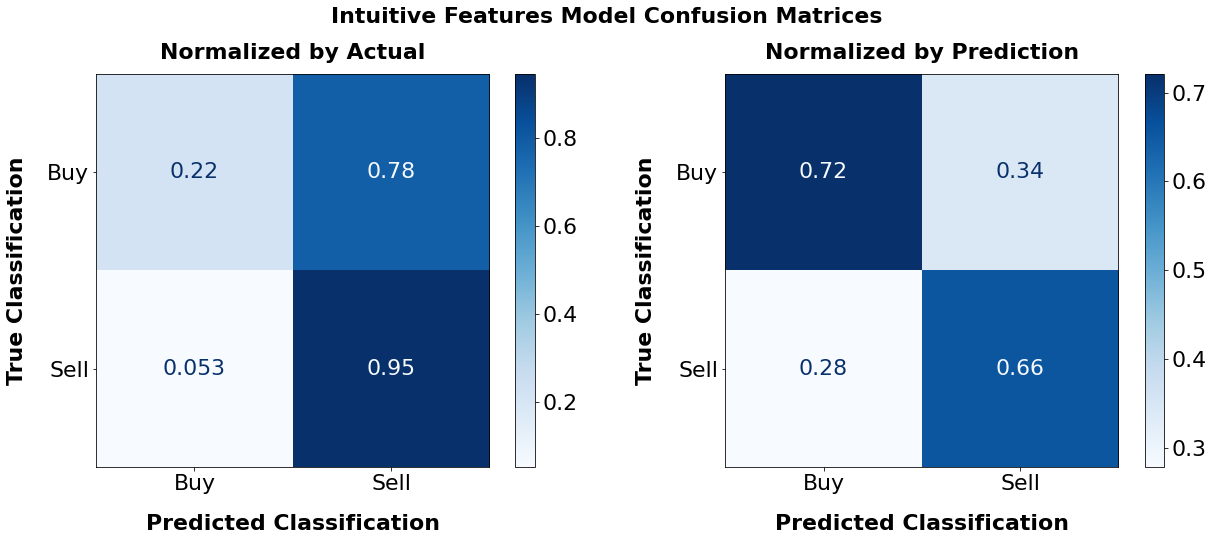


Intuitive Features Model Classification Metrics:

Accuracy:    66.35%
Precision:   65.58%
Recall:      94.69%
Specificity: 21.67%




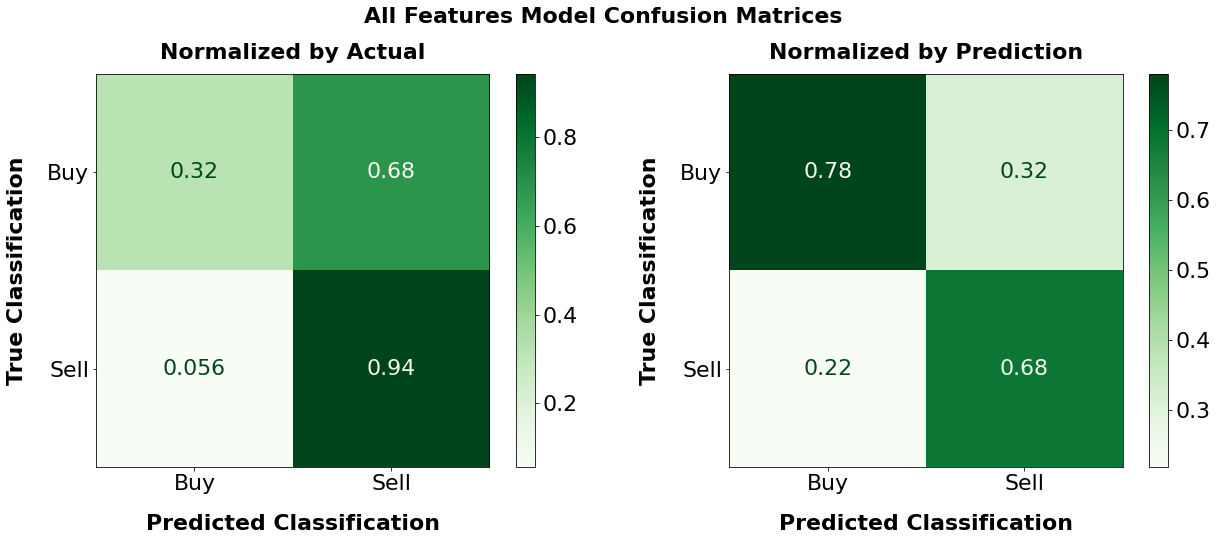


All Features Model Classification Metrics:

Accuracy:    69.98%
Precision:   68.48%
Recall:      94.38%
Specificity: 31.53%




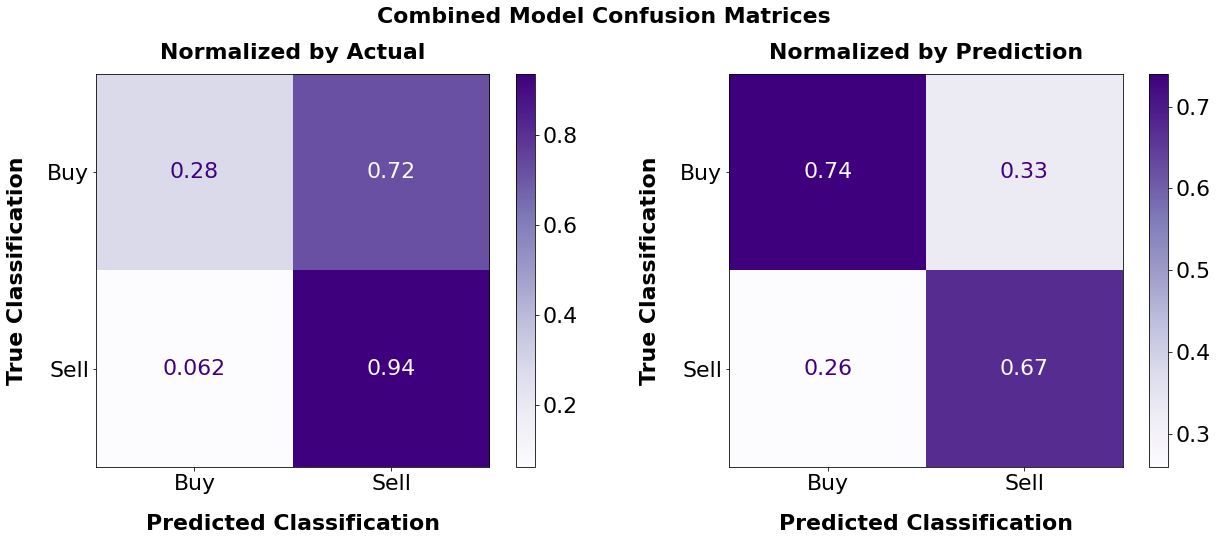


Combined Model Classification Metrics:

Accuracy:    68.26%
Precision:   67.26%
Recall:      93.75%
Specificity: 28.08%




In [79]:
plt.rcParams.update({'font.size': 22})

int_acc, int_prec, int_rec, int_spec = confusion(rfc=rf_classifier_intuitive, x_test=int_x_test, y_test=int_y_test, y_pred=int_y_pred,
                                                 model='Intuitive Features Model', cmap='Blues')
all_acc, all_prec, all_rec, all_spec = confusion(rfc=rf_classifier_all, x_test=all_x_test, y_test=all_y_test, y_pred=all_y_pred,
                                                 model='All Features Model', cmap='Greens')
com_acc, com_prec, com_rec, com_spec = confusion(rfc=rf_classifier_combined, x_test=com_x_test, y_test=com_y_test, y_pred=com_y_pred,
                                                 model='Combined Model', cmap='Purples')

# CREATE PANDAS DATAFRAME FROM DICTIONARY!!! ONE COLUMN PER MODEL!!! ROW INDEX SHOULD BE LABELS!!!

In [120]:
def feature_importance_df(rf_classifier, x_train, model_name):
    """
    Return dataframe with features and their importances for a given random forest model.
    """
    feature_importance = pd.Series(rf_classifier.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    df = pd.DataFrame(feature_importance).reset_index()
    df.columns = [model_name + ' - Features', model_name + ' - Importance']

    return df

intuitive_feature_importance = feature_importance_df(rf_classifier_intuitive, int_x_train, 'Intuitive')
all_feature_importance = feature_importance_df(rf_classifier_all, all_x_train, 'All')
combined_feature_importance = feature_importance_df(rf_classifier_combined, com_x_train, 'Combined')

In [139]:
# Display feature imporantance comparison for the three models
importance_comparison = intuitive_feature_importance.merge(all_feature_importance, how='outer', left_index=True, right_index=True)\
                                                    .merge(combined_feature_importance, how='outer', left_index=True, right_index=True)

importance_comparison['Intuitive - Features'].fillna('---', inplace=True)
importance_comparison['All - Features'].fillna('---', inplace=True)
importance_comparison['Combined - Features'].fillna('---', inplace=True)

cm = sns.light_palette("green", as_cmap=True)
importance_comparison.style.background_gradient(cmap=cm)

,Intuitive - Features,Intuitive - Importance,All - Features,All - Importance,Combined - Features,Combined - Importance
0,transaction_fees_30,0.194641,transaction_fees_30,0.194438,transaction_fees_30,0.207899
1,t_over_k_streak,0.177052,t_over_k_streak,0.178591,stfd,0.174614
2,stfd,0.171815,mining_difficulty_norm,0.170148,mining_difficulty_norm,0.160519
3,transactions_30,0.150066,rsi_reg_norm120,0.167489,price_over_cloud_top,0.157489
4,cloud_over_price,0.147831,stfd,0.159932,new_over_active_30,0.143592
5,new_over_active_30,0.138768,nupl,0.129402,nupl,0.137213
6,market_to_thermo,0.019827,---,nan,market_to_thermo,0.018675


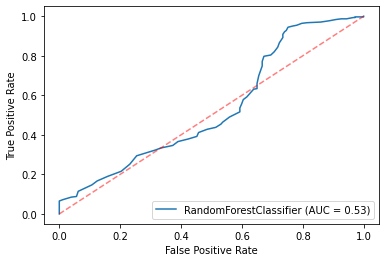

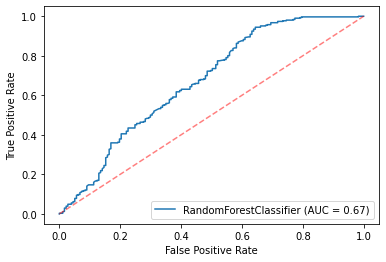

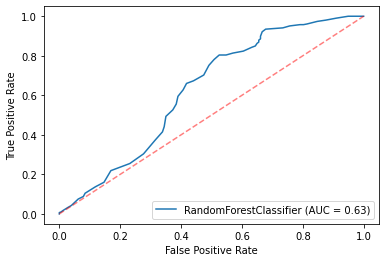

In [143]:
# Receiver Operating Characteristic (ROC) curve
intuitive_roc_plot = plot_roc_curve(rf_classifier_intuitive, int_x_test, int_y_test)
plt.plot([0,1], [0,1], linestyle='--', color='red', alpha=0.5)
all_roc_plot = plot_roc_curve(rf_classifier_all, all_x_test, all_y_test)
plt.plot([0,1], [0,1], linestyle='--', color='red', alpha=0.5)
combined_roc_plot = plot_roc_curve(rf_classifier_combined, com_x_test, com_y_test)
plt.plot([0,1], [0,1], linestyle='--', color='red', alpha=0.5)
plt.show()

In [982]:
# Out-Of-Bag Error
print('Random Forest Out-Of-Bag Error Score: {}'.format(rf_classifier.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.8304617505168849


# Future Work
- Build classifiers for different time periods (weekly, hourly)
- Build random forest regression model
- Compare results to a baseline "only up" mentatily. 